<a href="https://colab.research.google.com/github/emrapport/w266-final-project/blob/master/CNN_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11/3/2019
Overview: I used this notebook to just experiment with some different things I thought could help the model, where I didn't necessarily want to save off a new notebook for each one. Here is what I did:
- tried class weights where I weighted the female examples twice as high as male, by adding this param to model.fit: 
`class_weight={0: 2, 1: 1}`. The _training_ accuracy was higher, but the _validation_ accuracy was a bit lower, hovering between .76 and .81 over 10 epochs. Also, it was interesting that the biggest plurality of wrong predictions was the set of preds where model predicted woman but should have predicted man (see below)

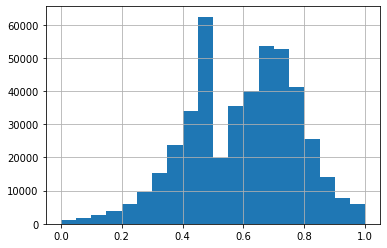

In [74]:
wrong_preds.probs.hist(bins=20)

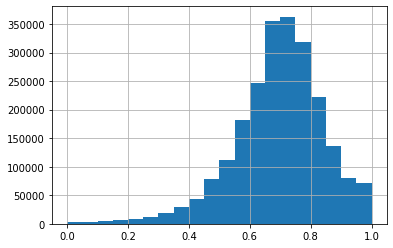

In [75]:
dev_df.probs.hist(bins=20)

- Next, I went back to the original case (no class weights) in order to generate a similar histogram to see if the pattern is different. This is pretty interesting. Here is what the wrong preds histogram for that looks like: 

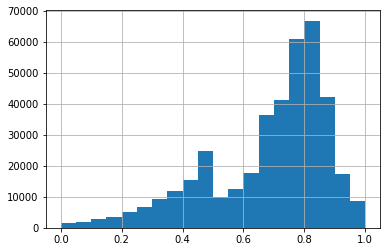

In [62]:
wrong_preds.probs.hist(bins=20)

And here's what the histogram of all predictions looks like:

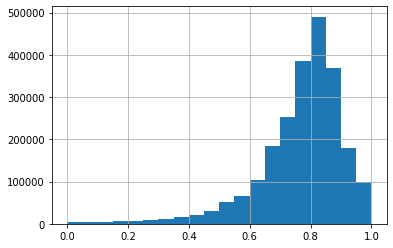

In [63]:
dev_df.probs.hist(bins=20)

So the shape of the overall distribution is pretty similar, but it's good that in the one where we privileged the other classes more, it's a little more skewed towards the middle...that seems good to me because ultimately we want the model to be more confident when it predicts female. 

- Now instead I want to try the thing where we remove from the training set examples where there are more than X number of responses to a given post. The theory being that maybe the model is over-optimizing towards these examples. This method seems to produce a _much_ more stable training experience than previous iterations - the validation loss is still going up and down a little over 12 epochs, but it never dips below .83 and usually is measured above .84. The output for the rest of the notebook reflects this final training attempt. I think the validation score stability is good reason to stick with this method moving forward, perhaps iterating on the threshold we use for the response-per-post cap. 

In [0]:
# this notebook is based off of this blog post: 
# https://realpython.com/python-keras-text-classification/#reader-comments

In [0]:
DATASET_NAME = "contractions"
MODEL_NAME = "contractions"
MAX_SEQ_LENGTH = 20
TRAINING_SET_SIZE = 4000000
VAL_SET_SIZE = 2000000
NUM_EPOCHS = 20
BATCH_SIZE = 1000
MAX_SEQUENCE_LENGTH = 20

# I don't think we have a good reason to do this right now
# but we might eventually 
SAVE_TOKENIZED_DATA = False

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
from scipy.sparse import hstack, vstack
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential, layers
from keras.utils import plot_model
import pandas as pd
import numpy as np
import copy
import time
import pickle
!pip install gcsfs

pd.set_option('max_colwidth', 100)

Using TensorFlow backend.


In [4]:
# this cell is only necessary if running in colab
project_id = 'w266-251323'
import uuid
bucket_name = 'fb-congressional-data/'
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {project_id}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Updated property [core/project].


In [77]:
train_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/train.csv", index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [78]:
dev_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/dev.csv", index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
num_responses_per_post = train_df.post_id.value_counts().reset_index()
num_responses_per_post.columns = ['post_id', 'num_responses']
too_big_posts = num_responses_per_post[num_responses_per_post.num_responses > 50]
posts_to_sample = too_big_posts.post_id.values
# this gets all the rows for posts we DON'T need to sample 
new_train_df = train_df[~train_df.post_id.isin(posts_to_sample)]
# this should be true
assert(len(too_big_posts) + new_train_df.post_id.nunique() == train_df.post_id.nunique())
too_big_post_rows = train_df[train_df.post_id.isin(posts_to_sample)]
sampled_rows = too_big_post_rows.groupby('post_id').apply(lambda x: x.sample(n=50)).reset_index(drop=True)
new_train_df = pd.concat([new_train_df, sampled_rows])
new_train_df.shape

In [0]:
# shuffle the data
# be sure to do this before you extract X's and y's!!
new_train_df = new_train_df.sample(frac=1)
dev_df = dev_df.sample(frac=1)

In [0]:
y_train = new_train_df.op_gender.values
y_dev = dev_df.op_gender.values

In [0]:
def turn_to_ints(li):
    final_list = []
    for gender in li:
        if gender=='M':
            final_list.append(1)
        else:
            final_list.append(0)
    return final_list
            
y_train = turn_to_ints(y_train)
y_dev = turn_to_ints(y_dev)

In [0]:
y_train = np.asarray(y_train)
y_dev = np.asarray(y_dev)

In [0]:
def get_text_list(init_list):
    sentences = []
    for sentence in init_list:
        if type(sentence) != str:
            sentences.append("")
        else:
            sentences.append(sentence)
    return sentences

new_sentences_train = get_text_list(new_train_df.response_text.values)
new_sentences_test = get_text_list(dev_df.response_text.values)

In [130]:
time_start = time.time()

# this is the default list of filters + apostrophe
# added because we have dealt with common contractions, so other apostrophes should mostly be possessive 
tokenizer = Tokenizer(num_words=200000, filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(new_sentences_train)

X_train = tokenizer.texts_to_sequences(new_sentences_train)
X_test = tokenizer.texts_to_sequences(new_sentences_test)

vocab_size = len(tokenizer.word_index) + 1

currentTime = time.gmtime(time.time() - time_start)

#Convert the gmtime struct to a string
timeStr = time.strftime("%M minutes, %S seconds", currentTime)

print("Tokenized in {}".format(timeStr))

Tokenized in 05 minutes, 24 seconds


In [0]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
if SAVE_TOKENIZED_DATA:
  x_train_path = 'X_train_{}.pkl'.format(DATASET_NAME)
  x_dev_path = 'X_dev_{}.pkl'.format(DATASET_NAME)
  y_train_path = 'y_train_{}.pkl'.format(DATASET_NAME)
  y_dev_path = 'y_dev_{}.pkl'.format(DATASET_NAME)

  with open(x_train_path, 'wb') as file:
      pickle.dump(X_train, file)   
  with open(x_dev_path, 'wb') as file:
      pickle.dump(X_test, file)
  with open(y_train_path, 'wb') as file:
      pickle.dump(y_train, file)
  with open(y_dev_path, 'wb') as file:
      pickle.dump(y_dev, file)

  # copy to bucket
  !gsutil cp /content/{x_train_path} gs://fb-congressional-data/test
  !gsutil cp /content/{x_dev_path} gs://fb-congressional-data/
  !gsutil cp /content/{y_train_path} gs://fb-congressional-data/
  !gsutil cp /content/{y_dev_path} gs://fb-congressional-data/

In [132]:
!gsutil cp gs://fb-congressional-data/glove* /tmp/

Copying gs://fb-congressional-data/glove.6B.100d.txt...
Copying gs://fb-congressional-data/glove.6B.200d.txt...
Copying gs://fb-congressional-data/glove.6B.300d.txt...
Copying gs://fb-congressional-data/glove.6B.50d.txt...
/ [4 files][  2.1 GiB/  2.1 GiB]   22.5 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://fb-congressional-data/glove.6B.zip...
- [5 files][  2.9 GiB/  2.9 GiB]   93.1 MiB/s                                   
Operation completed over 5 objects/2.9 GiB.                                      


In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 100
embedding_matrix = create_embedding_matrix(
                     '/tmp/glove.6B.{}d.txt'.format(embedding_dim),
                      tokenizer.word_index, embedding_dim)

In [134]:
# trying to figure out which words are empty here
counter = 0
empty_indexes = []
for index, row in enumerate(embedding_matrix):
  if sum(row) == 0:
    empty_indexes.append(index)
    counter += 1
  if counter > 1000:
    break

for idx in empty_indexes:
  try:
    print(tokenizer.index_word[idx])
  except:
    print("No entry for {}".format(idx))


No entry for 0
youtu
fbid
•
huffingtonpost
🇺🇸
washingtonpost
rinos
obummer
isil
cispa
bridenstine
🇺🇸🇺🇸
fbcdn
standwithrand
hphotos
aspx
lmao
👍
agsaf
thinkprogress
demandavote
2366
thehill
wenstrup
dailycaller
stillsanders
feelthebern
1073741828
repub
❤️
😊
sheeple
§
2646
daca
amodei
hahaha
doyourjob
p71bjjcp8
teabaggers
bucshon
bonamici
scontent
killary
washingtontimes
govtrack
sphotos
politicususa
libtards
fref
bengazi
tahmooressi
navient
opensecrets
teaparty
███
felicidades
obozo
westernjournalism
someunknownushistory
akamaihd
washingtonexaminer
hr1942
imho
timeisnow
kinzinger
banksters
cromnibus
cnsnews
nationalreview
gunviolencearchive
benifits
infowars
notif
koolaid
2fwww
latimes
nodapl
teabagger
abcnews
randpaul
oboma
على
hr2366
obamatrade
shouldnt
randrally
wtg
nobama
theguardian
romneycare
libtard
0bama
gofundme
kxl
occupydemocrats
berniesanders
s1214
motherjones
😡
tinyurl
hr2646
cbsnews
renewui
rouzer
╚═
═╝
nbwbd8jcjgy
dailymail
❤
businessinsider
hahahaha
sthash
pnref
katko
tru

In [135]:
# hmmmm....
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.22339953558531486

In [136]:
embedding_matrix.shape

(597311, 100)

In [154]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LENGTH, 
                           trainable=False))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 100)           59731100  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 59,796,529
Trainable params: 65,429
Non-trainable params: 59,731,100
_________________________________________________________________


In [0]:
smaller_X_dev = X_test[:VAL_SET_SIZE]
smaller_y_dev = y_dev[:VAL_SET_SIZE]

In [156]:
try:
  time_start = time.time()

  history = model.fit(X_train, y_train,
                      epochs=NUM_EPOCHS,
                      verbose=True,
                      validation_data=(smaller_X_dev, smaller_y_dev),
                      batch_size=BATCH_SIZE)

  currentTime = time.gmtime(time.time() - time_start)

  #Convert the gmtime struct to a string
  timeStr = time.strftime("%M minutes, %S seconds", currentTime)

  print("Trained in {}".format(timeStr))

except:
  currentTime = time.gmtime(time.time() - time_start)

  #Convert the gmtime struct to a string
  timeStr = time.strftime("%M minutes, %S seconds", currentTime)

  print("Trained in {}".format(timeStr))  

Train on 3962284 samples, validate on 2000000 samples
Epoch 1/20
3962284/3962284 [==============================] - 118s 30us/sample - loss: 0.5222 - acc: 0.7624 - val_loss: 0.4352 - val_acc: 0.8466
Epoch 2/20
3962284/3962284 [==============================] - 118s 30us/sample - loss: 0.5044 - acc: 0.7705 - val_loss: 0.4395 - val_acc: 0.8443
Epoch 3/20
3962284/3962284 [==============================] - 119s 30us/sample - loss: 0.4994 - acc: 0.7728 - val_loss: 0.4390 - val_acc: 0.8461
Epoch 4/20
3962284/3962284 [==============================] - 118s 30us/sample - loss: 0.4962 - acc: 0.7741 - val_loss: 0.4425 - val_acc: 0.8402
Epoch 5/20
3962284/3962284 [==============================] - 118s 30us/sample - loss: 0.4939 - acc: 0.7750 - val_loss: 0.4403 - val_acc: 0.8423
Epoch 6/20
3962284/3962284 [==============================] - 133s 33us/sample - loss: 0.4921 - acc: 0.7758 - val_loss: 0.4503 - val_acc: 0.8350
Epoch 7/20
3962284/3962284 [==============================] - 120s 30us/samp

In [157]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_dev, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.7802
Testing Accuracy:  0.8399


In [0]:
# can't get this to work
plot_model(history)

In [0]:
preds = model.predict(X_test)

In [0]:
dev_df['probs'] = preds

In [0]:
def pred_to_label(row):
  if row['probs'] >= .5:
    return 'M'
  else:
    return 'W'

dev_df['preds'] = dev_df.apply(pred_to_label, axis=1)

In [0]:
wrong_preds = dev_df[dev_df.op_gender!=dev_df.preds]

In [162]:
wrong_preds.op_gender.value_counts()

W    313968
M     53033
Name: op_gender, dtype: int64

In [163]:
# total proportion of preds for women
dev_df.preds.value_counts()['W'] / len(dev_df)

0.036460702505596604

In [164]:
#random sample of mistakes
wrong_preds.head(20)

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds
1844365,10877293,77721801,W,385172,Mona,"over 300,000 assyrians and 900,000 greeks vanished in the same genocide.",Anna Eshoo,Congress_Democratic,0.783043,M
2013549,11062941,86569077,W,390130,Kate,awesome.,Kirsten Gillibrand,Congress_Democratic,0.658747,M
1770827,10293964,32570461,M,382166,M,she s' good! i am with her.,Tim Kaine,Congress_Democratic,0.482180,W
1980884,11030276,86569077,W,389854,Gary,obama rocks :),Kirsten Gillibrand,Congress_Democratic,0.564093,M
1159694,6091468,19189340,W,209246,Barry,we should all shut down in solidarity!,Robin Kelly,Congress_Democratic,0.702381,M
96392,2252250,47977187,W,43582,Brenda,yes vote against session and devos,Catherine Cortez Masto,Congress_Democratic,0.763829,M
2028189,11077581,86569077,W,390318,Dwight,"ms.gillibrand, how can we vote for a candidate, who wipes her arse with the constitution?",Kirsten Gillibrand,Congress_Democratic,0.896453,M
1976218,11025610,86569077,W,389811,Frank,how about every american to get the same pay as members of congress does? and the same work sch...,Kirsten Gillibrand,Congress_Democratic,0.773900,M
1937122,10986514,86569077,W,389421,Vince,americans-- not democrats or republicans but us citizens. we americans voted these so-called re...,Kirsten Gillibrand,Congress_Democratic,0.770105,M
711129,4960183,46506154,M,160287,Morris,my rant on the iowa primary - the iowa primary is a joke. candidate's campaign for months to get...,Marco Rubio,Congress_Republican,0.483660,W


In [165]:
# most confident wrong predictions where the answer was F but they thought M
# same as before - references to a male politician 
wrong_preds.sort_values('probs', ascending=False)[:20]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds
2052572,11101964,86569077,W,390749,Peter,"damn, even jim inhofe is upset with bunning.",Kirsten Gillibrand,Congress_Democratic,0.999601,M
2136861,11277841,77234050,W,399896,Carol,"please senator mcmorris, support rand paul in his efforts to protect our rights to due process",Cathy McMorris Rodgers,Congress_Republican,0.999547,M
396494,3146585,23984618,W,83709,Dorrie,our rep peter defazio is like you in a lot of ways. oregon is lucky to have him,Ann Wagner,Congress_Republican,0.999530,M
2137043,11278023,77234050,W,399899,Billy,explain this: dhs-hsi homeland security investigations el paso srt mrap armored v http://www.y...,Cathy McMorris Rodgers,Congress_Republican,0.999528,M
2137691,11278671,77234050,W,399905,Billy,explain this: dhs-hsi homeland security investigations el paso srt mrap armored v http://www.you...,Cathy McMorris Rodgers,Congress_Republican,0.999528,M
2137467,11278447,77234050,W,399901,Billy,explain this: dhs-hsi homeland security investigations el paso srt mrap armored v http://www.you...,Cathy McMorris Rodgers,Congress_Republican,0.999528,M
2137557,11278537,77234050,W,399902,Billy,explain this: dhs-hsi homeland security investigations el paso srt mrap armored v http://www.you...,Cathy McMorris Rodgers,Congress_Republican,0.999528,M
1951491,11000883,86569077,W,389558,Sergio,thank you for doing so over mr. schumer. you are a real patriot!,Kirsten Gillibrand,Congress_Democratic,0.999418,M
2050568,11099960,86569077,W,390690,Desarosa,lucky you...I have got sen. burr,Kirsten Gillibrand,Congress_Democratic,0.999393,M
2134840,11275820,77234050,W,399849,Michele,congressman mcmorris: what are you going to do about this? we elected you to help represent us n...,Cathy McMorris Rodgers,Congress_Republican,0.999353,M


In [166]:
# most confident wrong predictions where the answer was F but they thought M
# same as before - references to a male politician 
wrong_preds.sort_values('probs', ascending=True)[:20]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds
912425,5161479,46506154,M,161120,Paula,"go marco! good luck, joni.",Marco Rubio,Congress_Republican,0.000059,W
912479,5161533,46506154,M,161121,Cheryl,"love marco rubio, good luck joni!!!",Marco Rubio,Congress_Republican,0.000126,W
887546,5136600,46506154,M,160986,Kim,good luck joni...................jan,Marco Rubio,Congress_Republican,0.000194,W
887235,5136289,46506154,M,160981,Sven,"trash scott brown all you want, but he is infinitely better in the senate than jeanne shaheen. j...",Marco Rubio,Congress_Republican,0.000217,W
887566,5136620,46506154,M,160986,Herb,http://www.politifact.com/truth-o-meter/statements/2014/sep/30/joni-ernst/braley-ernst-debate-an...,Marco Rubio,Congress_Republican,0.000224,W
2166055,11307035,95515852,M,401117,Jennifer,"happy to see rep. mia love there also, enjoyed her speech at the rally for life in january.",Bill Huizenga,Congress_Republican,0.000239,W
831709,5080763,46506154,M,160771,CrowdAlbum,checkout awesome attendee photos from the event! http://www.crowdalbum.com/album/5574740d2bbec9f...,Marco Rubio,Congress_Republican,0.000268,W
1806560,10329697,32570461,M,382375,Dave,angus king is a former governor of the state of maine. did you also make friends with former new...,Tim Kaine,Congress_Democratic,0.000311,W
1904674,10937602,10458808,M,386737,Oskar,you rock! keep holding obama accountable and do not jeopardize your ideals! i wish my congresswo...,Mark Takano,Congress_Democratic,0.000320,W
991634,5240688,46506154,M,161317,Laura,"keep the faith ms. ayotte, you are good for new hampshire and our country !! you have more supp...",Marco Rubio,Congress_Republican,0.000329,W


In [167]:
borderline_wrong_preds_m = wrong_preds[wrong_preds.probs.between(.5, .6)]

# this is how many wrong preds were in the "borderline" range
# where model predicted male instead of female
print(borderline_wrong_preds_m.shape[0]/wrong_preds.shape[0])

borderline_wrong_preds_m.head(40)

0.06131318443273997


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds
1980884,11030276,86569077,W,389854,Gary,obama rocks :),Kirsten Gillibrand,Congress_Democratic,0.564093,M
2289224,13624889,4938109,W,528398,Dionne,thank you for providing an opportunity to participate through this link. you are appreciated.,Yvette Clarke,Congress_Democratic,0.531395,M
2045450,11094842,86569077,W,390593,Adam,thanks for always fighting for us!!,Kirsten Gillibrand,Congress_Democratic,0.574062,M
1950134,10999526,86569077,W,389550,Mike,http://www.frontpagemag.com/fpm/259895/traitor-senators-took-money-iran-lobby-back-iran-daniel-g...,Kirsten Gillibrand,Congress_Democratic,0.520262,M
1997077,11046469,86569077,W,390020,Kelsey,now is the time for major reform - those bozos in the brass have made their utter disdain comple...,Kirsten Gillibrand,Congress_Democratic,0.577454,M
1948058,10997450,86569077,W,389524,Matthew,lol support her all the way to the pokey,Kirsten Gillibrand,Congress_Democratic,0.590919,M
2043785,11093177,86569077,W,390565,Michael,thanks for sharing these inspiration words!,Kirsten Gillibrand,Congress_Democratic,0.573257,M
500103,4144768,3795296,W,150559,Keith,http://www.masslive.com/politics/index.ssf/2014/01/massachusetts_rep_carlos_henri.html th...,Lois Frankel,Congress_Democratic,0.544796,M
1841890,10874818,77721801,W,384985,Eric,learn how hacking & fake news could quickly escalate into the next 9/11. it has the asymmetric ...,Anna Eshoo,Congress_Democratic,0.555547,M
1993051,11042443,86569077,W,389976,Matt,"length ?over 1000 pages. (yeah im sure kirsten didnt read it)cost? over 30,000,000,000 dollars ,...",Kirsten Gillibrand,Congress_Democratic,0.596417,M


In [168]:
borderline_wrong_preds_f = wrong_preds[wrong_preds.probs.between(.4, .5)]

# this is how many wrong preds were in the "borderline" range
# where model predicted female instead of male
print(borderline_wrong_preds_f.shape[0]/wrong_preds.shape[0])

borderline_wrong_preds_f.head(40)

0.07595347151642638


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds
1770827,10293964,32570461,M,382166,M,she s' good! i am with her.,Tim Kaine,Congress_Democratic,0.482180,W
711129,4960183,46506154,M,160287,Morris,my rant on the iowa primary - the iowa primary is a joke. candidate's campaign for months to get...,Marco Rubio,Congress_Republican,0.483660,W
1604169,10052039,49028900,M,365938,Eileen,why dont you like latinos thy dont own you nothing i dont care for you im from cali and very hap...,Steve King,Congress_Republican,0.401988,W
1423243,7841537,99469231,M,296324,Carrie,dang!!! you look older than her!!,John McCain,Congress_Republican,0.406954,W
813470,5062524,46506154,M,160692,Vicki,"the killing and selling of our most innocent and precious treasure by planned parenthood, a fede...",Marco Rubio,Congress_Republican,0.499278,W
563863,4812917,46506154,M,160146,Frank,"as a florida resident, i am appalled that you cannot endorse the republican nominee donald j tru...",Marco Rubio,Congress_Republican,0.466130,W
2241652,12500163,40220308,M,469182,Lori,"donald, obama is for motherhood. he thinks the government should be everybody's mamma. the mor...",Joe Barton,Congress_Republican,0.426365,W
1848490,10881418,10458808,M,385661,Rachel,amazing! thank you!,Mark Takano,Congress_Democratic,0.465246,W
440026,3584701,84716153,M,122248,Lisa,absolutely not! gorsuch is another bought and paid for minion of big business. he puts profit an...,Jeff Flake,Congress_Republican,0.469367,W
13236,2131151,38794897,M,36329,Marcia,"I am voting for her (and for you, too, if she picks you as her vp running mate, as i hope she wi...",Sherrod Brown,Congress_Democratic,0.469336,W


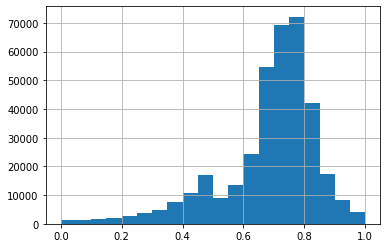

In [169]:
wrong_preds.probs.hist(bins=20)

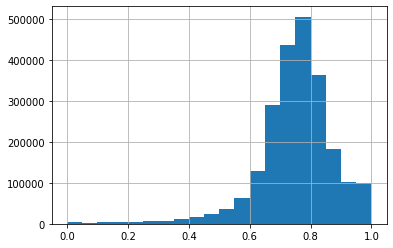

In [170]:
dev_df.probs.hist(bins=20)